In [346]:
from IPython import display
import tensorflow as tf

In [347]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D, InputSpec, Layer

In [348]:
def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [349]:
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

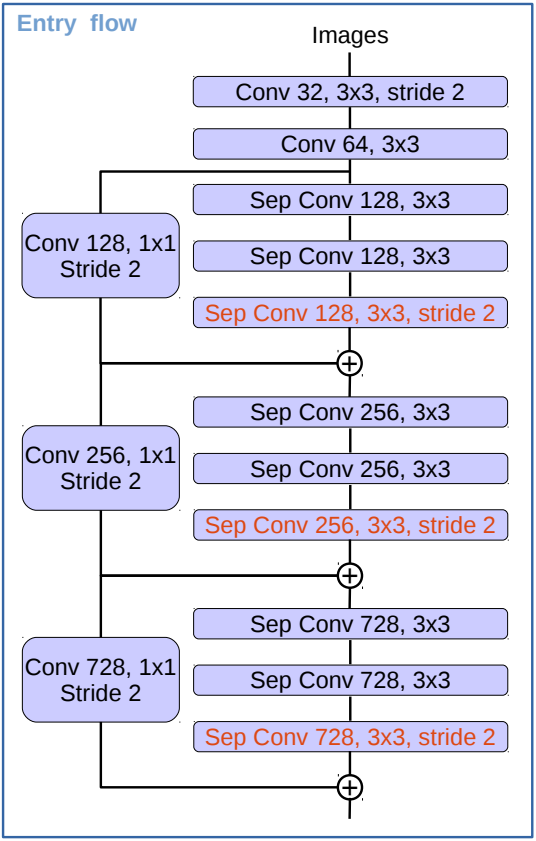

In [350]:
display.Image("./entry_flow.png")

In [351]:
def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = conv_bn(x, filters=64, kernel_size=3)
    skip = x
  
    x = sep_bn(x, filters=128, kernel_size=3)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = sep_bn(x, filters=128, kernel_size=3, strides=2)
    
    skip = conv_bn(skip, filters=128, kernel_size=1, strides=2)
    x = Add()([skip, x])
    
    x = sep_bn(x, filters=256, kernel_size=3)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = sep_bn(x, filters=256, kernel_size=3, strides=2)

    skip = conv_bn(skip, filters=256, kernel_size=1, strides=2)
    x = Add()([skip, x])

    x = sep_bn(x, filters=728, kernel_size=3)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = sep_bn(x, filters=728, kernel_size=3, strides=2)

    skip = conv_bn(skip, filters=728, kernel_size=1, strides=2)
    x = Add()([skip, x])
    return x

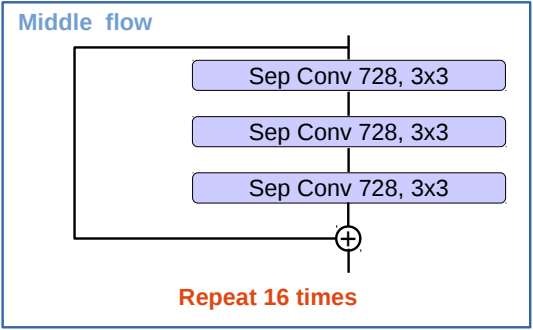

In [352]:
display.Image("./middle_flow.png")

In [353]:
def middle_flow(skip):
    for _ in range(16):
        x = sep_bn(skip, filters=728, kernel_size=3)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = sep_bn(x, filters=728, kernel_size=3)
        skip = Add()([skip, x])

    return skip

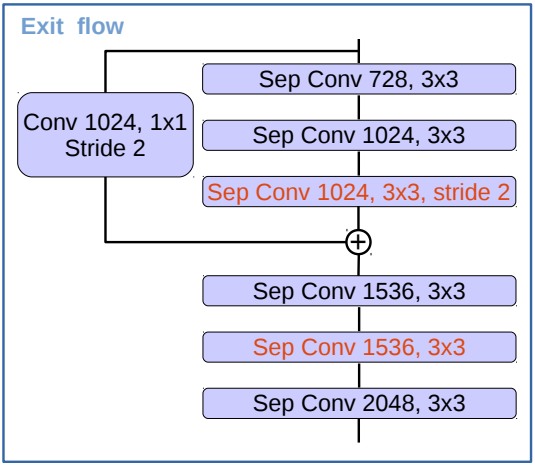

In [354]:
display.Image("./exit_flow.png")

In [355]:
def exit_flow(skip):
    # print(skip.shape)
    x = sep_bn(skip, filters=728, kernel_size=3)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = sep_bn(x, filters=1024, kernel_size=3, strides=2)
    # print(x.shape)
    skip = conv_bn(skip, filters=1024, kernel_size=1, strides=2)
    x = Add()([skip, x])
    # print(x.shape)
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = sep_bn(x, filters=2048, kernel_size=3)
    # print(x.shape)
    return x

In [356]:
def Xception(input):
    x = entry_flow(input)
    x = middle_flow(x)
    output = exit_flow(x)
    return output

In [357]:
# input = Input(shape=[299, 299, 3])
# output = Xception(input)

In [358]:
from tensorflow.keras import Model 
# model = Model(input, output)

In [359]:
from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes = False)

In [360]:
import tensorflow.keras.backend as K
def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format

In [361]:
from tensorflow.keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Input,DepthwiseConv2D,add,Dropout,AveragePooling2D,Concatenate,UpSampling2D, Lambda
import tensorflow.keras.utils as conv_utils
from tensorflow.keras.utils import normalize

In [362]:
def aspp(x, input_shape, out_stride):
    def aspp_unit(b, dilation_rate = (1,1)):
        if dilation_rate != (1,1):
            b = DepthwiseConv2D((3,3), dilation_rate = dilation_rate, padding = "same", use_bias = False)(b)
            b = BatchNormalization()(b)
            b = Activation("relu")(b)
        b = Conv2D(256, (1,1), padding = "same", use_bias = False)(b)
        # b = BatchNormalization()(b)
        b = BatchNormalization(epsilon=1e-5)(b)
        b = Activation("relu")(b)
        return b
    b0 = aspp_unit(x)
    b1 = aspp_unit(x, (6,6))
    b2 = aspp_unit(x, (12,12))
    b3 = aspp_unit(x, (18,18))

    b4 = GlobalAvgPool2D()(x)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = aspp_unit(b4)
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3], method='bilinear', align_corners=True))(b4)
    
    x=Concatenate()([b4,b0,b1,b2,b3])
    x = aspp_unit(x)
    return x

In [363]:
def deeplabv3plus(input_shape = [256, 256, 3], out_stride = 16, num_classes = 10):
    img_input = Input(input_shape)
    x = Xception(img_input)
    x = aspp(x, input_shape, out_stride)
    print(x.shape)
    model = Model(img_input, x)
    return model


In [364]:
model = deeplabv3plus()
model.summary()

(None, 8, 8, 256)
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 128, 128, 32) 864         input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1108 (Batch (None, 128, 128, 32) 128         conv2d_196[0][0]                 
__________________________________________________________________________________________________
activation_678 (Activation)     (None, 128, 128, 32) 0           batch_normalization_1108[0][0]   
_________________________________________________________________________

In [365]:
from tensorflow.python.keras.utils.data_utils import get_file

In [366]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH_X, cache_subdir='models')

In [367]:
model.load_weights(weights_path, by_name=False)

ValueError: You are trying to load a weight file containing 293 layers into a model with 156 layers.